In [224]:
import os
import pandas as pd
import numpy as np
import math

#------ for model evaluation -----
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#----- for preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

#---- for model building
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#---- for visualization---
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split

In [225]:
os.chdir("C:/Users/SAURABH SHRIVASTAVA/OneDrive/Data Scientist/Edwisor project 2")
os.getcwd()

'C:\\Users\\SAURABH SHRIVASTAVA\\OneDrive\\Data Scientist\\Edwisor project 2'

In [226]:
cab_data = pd.read_csv("C:/Users/SAURABH SHRIVASTAVA/OneDrive/Data Scientist/Edwisor project 2/train_cab.csv")
print(cab_data.head())

  fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0         4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1        16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   
2         5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270   
3         7.7  2012-04-21 04:30:42 UTC        -73.987130        40.733143   
4         5.3  2010-03-09 07:51:00 UTC        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278              1.0  
1         -73.979268         40.782004              1.0  
2         -73.991242         40.750562              2.0  
3         -73.991567         40.758092              1.0  
4         -73.956655         40.783762              1.0  


# Data Preprocesssing

### Data Exploring, cleaning and invalid removal

In [227]:
def data_clean(cab_df):
    
    #checking the datatype of each variable
    print("Shape of dataframe -----", cab_df.shape)
    print("\nData type of each Variable are-------------\n")
    print(cab_df.info())
    
    #Converting datatype
    if("fare_amount" in cab_df.columns):
        cab_df['fare_amount']=pd.to_numeric(cab_df['fare_amount'], errors='coerce')
    cab_df['pickup_datetime']=pd.to_datetime(cab_df['pickup_datetime'], errors='coerce')
    cab_df.info()
    
    #Getting years, month, time from datetime variable
    cab_df['pickup_year']= cab_df['pickup_datetime'].dt.year
    cab_df['pickup_month']=cab_df['pickup_datetime'].dt.month
    cab_df['pickup_month_day']=cab_df['pickup_datetime'].dt.day
    cab_df['pickup_hour']=cab_df['pickup_datetime'].dt.hour
    cab_df['pickup_minute']=cab_df['pickup_datetime'].dt.minute
    cab_df['pickup_second']=cab_df['pickup_datetime'].dt.second
    
    #Droping pickup date time
    cab_df=cab_df.drop(['pickup_datetime'], axis=1)
    cab_df=cab_df.drop(['pickup_second'], axis=1)
    cab_df=cab_df.drop(['pickup_minute'], axis=1)
    cab_df.head()
    print("\nShape of dataframe:",cab_df.shape)
    
    #removing invalid values
    if("fare_amount" in cab_df.columns):
        cab_df=cab_df[cab_df["fare_amount"]>1]
    cab_df=cab_df[cab_df["pickup_longitude"]!=0]
    cab_df=cab_df[cab_df["dropoff_longitude"]!=0]
    cab_df=cab_df[cab_df["pickup_latitude"]!=0]
    cab_df=cab_df[cab_df["dropoff_latitude"]!=0]
    
    #Since in normal situtation, can not have passenger more than 7, 
    #which include 1-driver also, so we will drop passenger count more than 6
    cab_df=cab_df[cab_df["passenger_count"]<7]
    cab_df=cab_df[cab_df["passenger_count"]>=1]
    print("\nShape of dataframe:",cab_df.shape)
    #cab_df.describe()
    
    #checking latitude and longitude for its valid range
    #latitude : -90 to 90
    #longtitude : -180 to 180
    
    cab_df=cab_df[cab_df["dropoff_latitude"]>=-90] 
    cab_df=cab_df[cab_df["dropoff_latitude"]<=90]
    cab_df=cab_df[cab_df["pickup_latitude"]>=-90] 
    cab_df=cab_df[cab_df["pickup_latitude"]<=90]
    cab_df=cab_df[cab_df["dropoff_longitude"]>=-180] 
    cab_df=cab_df[cab_df["dropoff_longitude"]<=180]
    cab_df=cab_df[cab_df["pickup_longitude"]>=-180] 
    cab_df=cab_df[cab_df["pickup_longitude"]<=180]
    
    
#    (cab_df[cab_df["dropoff_latitude"]<-90] & cab_df[cab_df["dropoff_latitude"]>90]).shape # no invalid found
#    (cab_df[cab_df["pickup_latitude"]<-90] & cab_df[cab_df["pickup_latitude"]>90]).shape #single observation found
#    (cab_df[cab_df["dropoff_longitude"]<-180] & cab_df[cab_df["dropoff_longitude"]>180]).shape # no invalid
#    (cab_df[cab_df["dropoff_longitude"]<-180] & cab_df[cab_df["dropoff_longitude"]>180]).shape # no invalid
    
    #dropping observation ranging outside -90 to 90 for latitude
 #   cab_df=cab_df[cab_df["pickup_latitude"]>-90]
 #   cab_df=cab_df[cab_df["pickup_latitude"]<90]
    print("\nData Cleaning done, Invalid value removed..\n")
    
    return cab_df


In [228]:
def Missing_value(cab_df):
    #checking missing value
    print(pd.DataFrame(cab_df.isna().sum(), columns={'Missing Value'}))
    
    #For missing value in current scenario , we can use mode/median. 
    #But since single observation only have all missing value we can just drop that single observation
    cab_df=cab_df.dropna()
    print("\nShape of data after missing value removal",cab_df.shape)
        
    return cab_df


Converting cordinates to distance

In [229]:
def find_distance(cab_df):
    
    #!pip install haversine
    import haversine as hs
    temp=[]
    range(cab_df.shape[0])
    
    for i in range(cab_df.shape[0]):
        temp.append(hs.haversine((cab_df["pickup_latitude"].iloc[i],cab_df["pickup_longitude"].iloc[i]),(cab_df["dropoff_latitude"].iloc[i],cab_df["dropoff_longitude"].iloc[i])))
    cab_df["distance"]=temp
    cab_df["distance"]=round(cab_df["distance"],2)
    cab_df["distance"].describe()
    cab_df.nlargest(10, ["distance"])
    cab_df=cab_df.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"], axis=1)
    cab_df.shape
    print("\nDistance feature created in our dataset, pickup and dropoff cordinates are removed\n")
    
    return cab_df

### Outlier Analysis

In [230]:
def Outlier(cab_df):
    #using box plot analysis
    
        
    #boxplot for distance
    plt.figure(figsize=(7,3))
    plt.boxplot(cab_df['distance'])
    plt.ylabel('distance')
    plt.title("Boxplot for distance")
        
    #boxplot for fare_amount
    
    if("fare_amount" in cab_df.columns):
        plt.figure(figsize=(7,3))
        plt.boxplot(cab_df['fare_amount'])
        plt.ylabel('fare_amount')
        plt.title("Boxplot for fare_amount")
 
    ###### Removing outlier ##############
    
    if("fare_amount" in cab_df.columns):
        #checking the largest top-10 fare_amount
        print("Top 10 Largest fare data are\n", cab_df["fare_amount"].nlargest(10))
        print("Top 10 Smallest fares data are\n", cab_df["fare_amount"].nsmallest(10))
        #removing the outlier fare_amount
        cab_df=cab_df[cab_df["fare_amount"]<=453]
        cab_df=cab_df[cab_df["fare_amount"]>1]
    
    #checking largest top-10 distance
    cab_df.nlargest(10, ["distance"])
    
    #removing the outlier fare_amount
    cab_df=cab_df[cab_df["distance"]<130]
    cab_df=cab_df[cab_df["distance"]!=0]
    
    #removing invalid passenger count
    cab_df=cab_df[cab_df["passenger_count"]!=1.3]
    print("\nOutlier are removed...")
    
    return cab_df

In [231]:
def Anova(cab_df):
    cat_variable=["passenger_count", "pickup_year", "pickup_month", "pickup_month_day", "pickup_hour"]
    
    #Doing Anova Test for correlation analysis, for catagorical attributes
    for i in cat_variable:
        f, p = stats.f_oneway(cab_df[i], cab_df["fare_amount"])
        print("\nANOVA TEST: P value for variable "+str(i)+" is "+str(p))
        #print("f value for variable "+str(i)+" is "+str(f))

        #We see p-value for all variables is below 0.05, hence no variable is required to be dropped
        
    return cab_df

### Feature Scaling

In [232]:
def Scaling(cab_df):
    
    #checking varible distribution for continous varible
    sns.distplot(cab_df['distance'],bins='auto',color='blue')
    plt.title("Variable Distribution for distance")
    plt.xlabel('distance')
    plt.show() 
    
    if "fare_amount" in cab_df.columns:
        #checking varible distribution for continous varible
        sns.distplot(cab_df['fare_amount'],bins='auto',color='blue')
        plt.title("Variable Distribution for fare_amount")
        plt.xlabel('fare_amount')
        plt.show() 
    
    
    #Removing skewness of data
    cnames=["fare_amount", "distance"]
    #using logarithm transformation for reducing skewness
    
    if("fare_amount" in cab_df.columns):
        cab_df['fare_amount'] = np.log1p(cab_df['fare_amount'])
    cab_df['distance'] = np.log1p(cab_df['distance'])
    
    #rechecking the skewness after log transformation, 
    #since our skewness reduced, we do not requires scaling technique further like normalisation and standardisation
    
    print("\nDistribution after Scaling..\n")
    
    #checking varible distribution for continous varible
    sns.distplot(cab_df['distance'],bins='auto',color='blue')
    plt.title("Variable Distribution for distance")
    plt.xlabel('distance')
    plt.show() 
    
    if "fare_amount" in cab_df.columns:
        #checking varible distribution for continous varible
        sns.distplot(cab_df['fare_amount'],bins='auto',color='blue')
        plt.title("Variable Distribution for fare_amount")
        plt.xlabel('fare_amount')
        plt.show() 
    
    return cab_df

#### Creating Dummy Variable for Categorical features

In [233]:
def Create_dummy(cab_df):
    
    #Creating dummy variable
    cab = pd.get_dummies(data = cab_df, columns = cat_variable)
    return cab

Shape of dataframe ----- (16067, 7)

Data type of each Variable are-------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime6

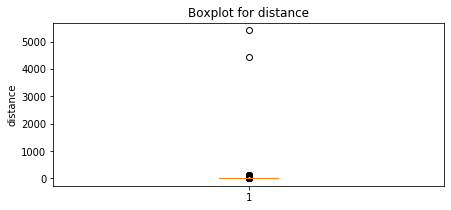

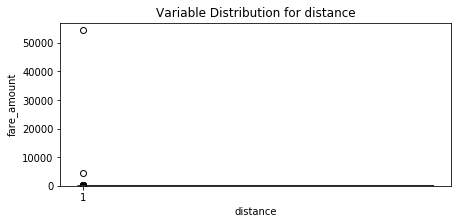

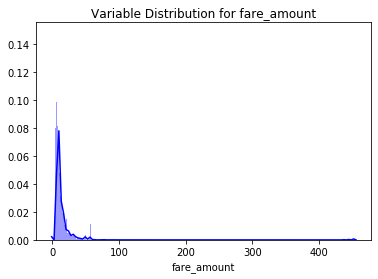


Distribution after Scaling..



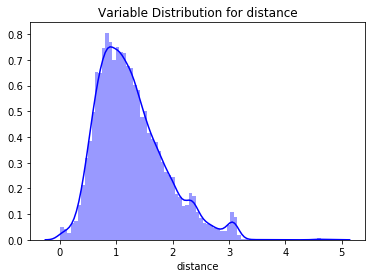

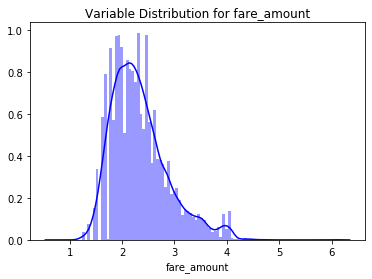

In [234]:
#Using all fucntion defined above

cab_data=data_clean(cab_data)
cab_data=Missing_value(cab_data)
cab_data=find_distance(cab_data)
cab_data=Outlier(cab_data)
cab_data=Anova(cab_data)
cab_data=Scaling(cab_data)
#cab_data=Create_dummy(cab_data) #Adding or removing dummy variable not affecting the model much.

#### Train Test Split 

In [235]:
#Train and test split
Y = cab_data['fare_amount']
X = cab_data.drop(['fare_amount'], axis=1)
# Using train_test_split sampling function for test and train data split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20, random_state=4)
print("Shape of train data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)

Shape of train data:  (12314, 6)
Shape of test data:  (3079, 6)


In [236]:
#Checking for parameter giving the best accuracy in terms R-Square value

#r2=[]
#random=[]

#for i in range(34):
#    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=i)
#    fit_GB = GradientBoostingRegressor().fit(X_train, y_train)
#    pred_test = fit_GB.predict(X_test)
#    r2.append(r2_score(y_test,pred_test))
#    random.append(i)

#for test size 0.2, Gradeient Boosting
# Create the pandas DataFrame 
#df = pd.DataFrame(r2, columns = ['r2_Score'])
#df["Random"]=random
#df.nlargest(5, ["r2_Score"])

In [237]:
#Linear Regression MULTIPLE

#Import libraries for LR
import statsmodels.api as sm

# Train the model using the training sets
model = sm.OLS(y_train, X_train).fit()
# predictions for train model
predictions_LR = model.predict(X_train)
# Calulating RMSE
print('Root Mean Squared Error of train:', np.sqrt(mean_squared_error(y_train,predictions_LR)))
# predictions for train model
predictions_LR = model.predict(X_test)
# Calulating RMSE
RMSE_test_LR = np.sqrt(mean_squared_error(y_test,predictions_LR))
print('Root Mean Squared Error of test:',RMSE_test_LR)
## R2 ##
R2_LR=r2_score(y_test,predictions_LR)
print("R^2 Score = "+str(R2_LR))


model.summary()

Root Mean Squared Error of train: 0.27135734048126503
Root Mean Squared Error of test: 0.25619949155139743
R^2 Score = 0.7678651726819854


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            fare_amount   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.584e+05
Date:                Sat, 21 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:12:08   Log-Likelihood:                         -1411.4
No. Observations:               12314   AIC:                                      2835.
Df Residuals:                   12308   BIC:                                      2879.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
passenger_count      0.0053      0.002      2.726      0.006       0.001       0.009
pickup_year          0.0007   5.16e-06    126.081      0.000       0.001       0.001
pickup_month         0.0041      0.001      5.824      0.000       0.003       0.006
pickup_month_day    -0.0003      0.000     -0.955      0.339      -0.001       0.000
pickup_hour          0.0007      0.000      1.939      0.053    -8.1e-06       0.001
distance             0.7782      0.004    193.143      0.000       0.770       0.786
==============================================================================
Omnibus:                     4112.001   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           502237.400
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                      34.267   Cond. No.                     3.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [238]:
#Decision Tree Regressor #####################
fit_DT = DecisionTreeRegressor(max_depth = 2).fit(X_train,y_train)
#prediction on train data
pred_train_DT = fit_DT.predict(X_train)
#prediction on test data
pred_test_DT = fit_DT.predict(X_test)

##calculating RMSE for train data
RMSE_train_DT = np.sqrt(mean_squared_error(y_train, pred_train_DT))
##calculating RMSE for test data
RMSE_test_DT = np.sqrt(mean_squared_error(y_test, pred_test_DT))
print("Root Mean Squared Error For Training data = "+str(RMSE_train_DT))
print("Root Mean Squared Error For Test data = "+str(RMSE_test_DT))

## R^2 calculation for test data
R2_DT=r2_score(y_test, pred_test_DT)
print("R^2 Score = "+str(R2_DT))



Root Mean Squared Error For Training data = 0.2932231790670182
Root Mean Squared Error For Test data = 0.2818550752680866
R^2 Score = 0.7190458221114435


In [239]:
#Random Forest
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
model = RandomForestRegressor(n_estimators=100, random_state=20).fit(X_train, y_train)
y_pred = model.predict(X_train)
print('Root Mean Squared Error for train:', np.sqrt(mean_squared_error(y_train, y_pred)))
test_pred = model.predict(X_test)
RMSE_test_RF=np.sqrt(mean_squared_error(y_test,test_pred))
print('Root Mean Squared Error for test:', RMSE_test_RF)
## R2 ##
R2_RF=r2_score(y_test,test_pred)
print("R^2 Score = "+str(R2_RF))

Root Mean Squared Error for train: 0.09504469664130388
Root Mean Squared Error for test: 0.24387271976700473
R^2 Score = 0.7896656425007441


In [254]:
#Gradient Boosting ####################

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Building model on top of training dataset
fit_GB = GradientBoostingRegressor(random_state=200).fit(X_train, y_train)
# Calculating RMSE for training data to check for over fitting
pred_train = fit_GB.predict(X_train)
# Calulating RMSE
print('Root Mean Squared Error of train:', np.sqrt(mean_squared_error(y_train,pred_train)))
# Calculating RMSE for test data to check accuracy
pred_test = fit_GB.predict(X_test)
# Calulating RMSE
RMSE_test_GB=np.sqrt(mean_squared_error(y_test,pred_test))
print('Root Mean Squared Error of test:', RMSE_test_GB)
R2_GB=r2_score(y_test,pred_test)
print("R^2 Score for test = "+str(R2_GB))

Root Mean Squared Error of train: 0.22688438724026877
Root Mean Squared Error of test: 0.22594141166839168
R^2 Score for test = 0.8194591630191854


In [241]:
#Out of all below model, we see Gradient Bossting giving better R2-Square and lesser RMSE. 
#Hence we select Gradient Boosting model.

In [242]:
measure_table = {'Model': ['Linear Regression','Decision Tree','Random Forest','Gradient Boosting'],
        'RMSE': [RMSE_test_LR,RMSE_test_DT,RMSE_test_RF,RMSE_test_GB],
        'R-Square': [R2_LR,R2_DT,R2_RF,R2_GB],
        }

print("\n Summary for all model")
print("-----------------------------------------")
print(pd.DataFrame(measure_table, columns = ['Model', 'RMSE', 'R-Square']))


 Summary for all model
-----------------------------------------
               Model      RMSE  R-Square
0  Linear Regression  0.256199  0.767865
1      Decision Tree  0.281855  0.719046
2      Random Forest  0.243873  0.789666
3  Gradient Boosting  0.225931  0.819475


#### From Above Summary, We see Gradeient Boosting Model has lesser RMSE and Higher R-Square value, so we will select Gradient Boosting model as best Model.

## predicting given test data

Shape of dataframe ----- (9914, 6)

Data type of each Variable are-------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB

Shape of dataframe: (9914, 9)

Shape o

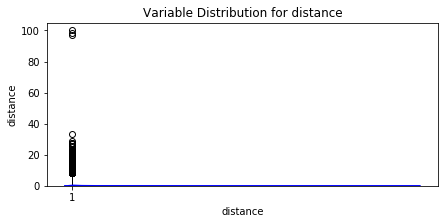


Distribution after Scaling..



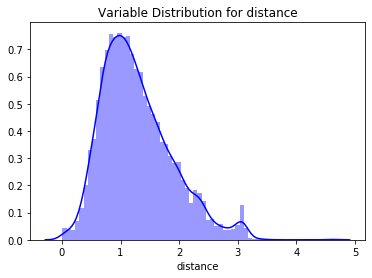

In [243]:
test_data = pd.read_csv("C:/Users/SAURABH SHRIVASTAVA/OneDrive/Data Scientist/Edwisor project 2/test.csv")

test_data=data_clean(test_data)
test_data=Missing_value(test_data)
test_data=find_distance(test_data)
test_data=Outlier(test_data)
test_data=Scaling(test_data)


In [244]:
#Selecting Gradient Boosting model, to predict given test data
pred_new = fit_GB.predict(test_data)

In [245]:
test_data["Predicted Fare"]=pred_new

test_data.to_csv("C:/Users/SAURABH SHRIVASTAVA/OneDrive/Data Scientist/Edwisor project 2/predicted_test.csv")
test_data.head(5)

,passenger_count,pickup_year,pickup_month,pickup_month_day,pickup_hour,distance,Predicted Fare
0,1,2015,1,27,13,1.199965,2.359394
1,1,2015,1,27,13,1.232560,2.412904
2,1,2011,10,8,11,0.482426,1.733264
3,1,2012,12,1,21,1.085189,2.199160
4,1,2012,12,1,21,1.854734,2.735288


# Data Visualisation

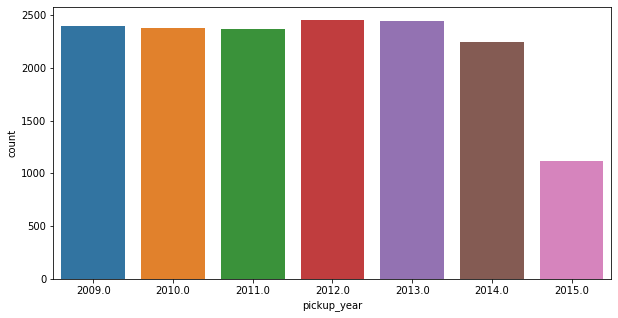

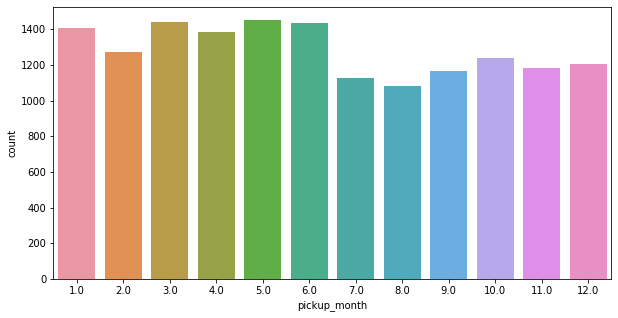

In [246]:
############################## Bar plot of fare amount vs passenger count ####
############################## Bar plot of fare amount vs Pickup year ########
# Trip distance vs fare amount
#plt.subplots(111, figsize=(12,6))
#fig.figure()

plt.figure(figsize=(10,5))
sns.countplot(cab_data['pickup_year'])
#Cab Count for Year 2015 is less as compared to other previous year.

plt.figure(figsize=(10,5))
sns.countplot(cab_data['pickup_month'])
#Cab counts are less from 7th to 12th Month i.e. July to December Month

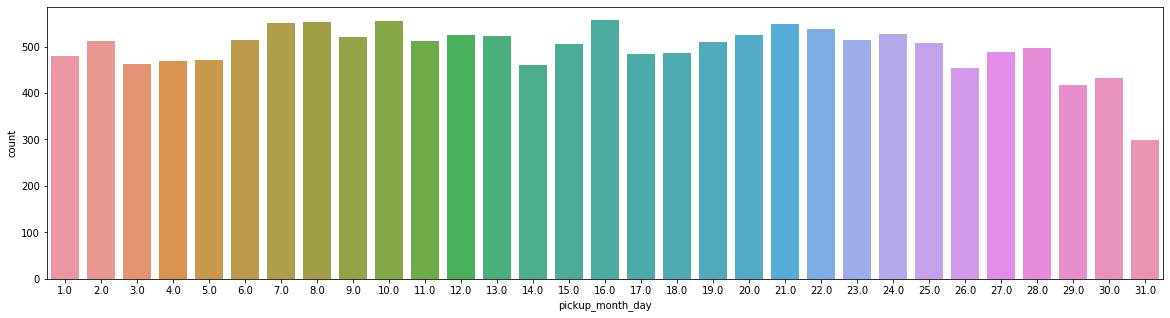

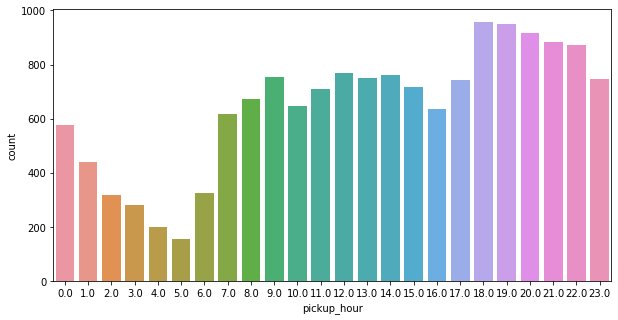

In [247]:
plt.figure(figsize=(20,5))
sns.countplot(cab_data['pickup_month_day'])
#Last Month days cab taken are less

plt.figure(figsize=(10,5))
sns.countplot(cab_data['pickup_hour'])
#Cab requirement is in peak from 6P.M to 11P.M, whereas cab count are less in morning i.e 2A.M to 6A.M

Text(0.5, 1.0, 'PLot')

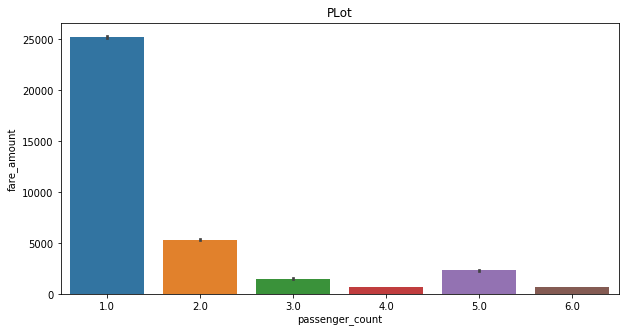

In [248]:
#Plot between passenger count and fare amount
plt.figure(figsize=(10,5))
sns.barplot(x='passenger_count', y='fare_amount', data=cab_data, estimator=sum).set_title("PLot")

#Cab fare are highest for single passengers

Text(0.5, 0, 'Passenger Count')

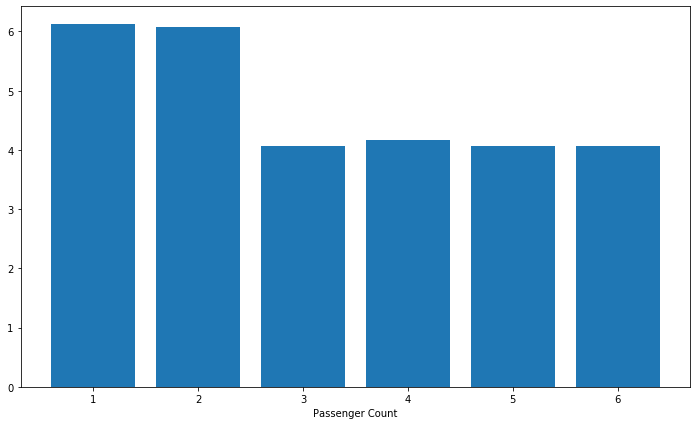

In [249]:
plt.figure(figsize=(12,7))
plt.bar(cab_data["passenger_count"], cab_data['fare_amount'])
plt.xlabel("Passenger Count")